In [1]:
from dotenv import load_dotenv
load_dotenv(dotenv_path='.env')

True

# Multi-vector retriever

In [2]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

file_path = "./mixed_data/ESLII_print12_toc (1).pdf"

loader = PyPDFLoader(file_path=file_path)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=0,
)

sl_data = loader.load_and_split(text_splitter=text_splitter)
sl_data[0]

Document(page_content='Springer Series in Statistics\nTrevor Hastie\nRobert TibshiraniJerome FriedmanSpringer Series in Statistics\nThe Elements of\nStatistical Learning\nData Mining, Inference, and Prediction\nThe Elements of Statistical LearningDuring the past decade there has been an explosion in computation and information tech-', metadata={'source': './mixed_data/ESLII_print12_toc (1).pdf', 'page': 0})

In [3]:
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

vectorstore = Chroma(
    collection_name="statistical_learning",
    embedding_function=OpenAIEmbeddings(),
)

docstore = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

In [4]:
import uuid

docs_ids = [str(uuid.uuid4()) for _ in sl_data]

In [5]:
child_text_splitter = RecursiveCharacterTextSplitter(chunk_size=400)

all_sub_docs = []
for i, doc in enumerate(sl_data):
    sub_docs = child_text_splitter.split_documents([doc])

    for sub_doc in sub_docs:
        sub_doc.metadata[id_key] = docs_ids[i]

    all_sub_docs.extend(sub_docs)

In [6]:
retriever.vectorstore.add_documents(all_sub_docs)

retriever.docstore.mset(list(zip(docs_ids, sl_data)))

In [7]:
retriever.vectorstore.similarity_search("Linear regression")

[Document(page_content='100 3. Linear Methods for Regression', metadata={'doc_id': '515ecda2-21c8-495c-b006-119a74e87f19', 'page': 118, 'source': './mixed_data/ESLII_print12_toc (1).pdf'}),
 Document(page_content='2.3 Least Squares and Nearest Neighbors 13\nLinear Regression of 0/1 Response', metadata={'doc_id': '74ab633d-e851-4a3b-916b-a05fc4d4dea2', 'page': 31, 'source': './mixed_data/ESLII_print12_toc (1).pdf'}),
 Document(page_content='54 3. Linear Methods for Regression\nx1x2y\nˆ yz z z z z\nFIGURE 3.4. Least squares regression by orthogonalization of the inputs . The\nvectorx2is regressed on the vector x1, leaving the residual vector z. The regres-\nsion ofyonzgives the multiple regression coeﬃcient of x2. Adding together the\nprojections of yon each of x1andzgives the least squares ﬁt ˆy.', metadata={'doc_id': 'd75eb5e5-bf58-4f68-9a82-b16c7ae7c0ea', 'page': 72, 'source': './mixed_data/ESLII_print12_toc (1).pdf'}),
 Document(page_content='44 3. Linear Methods for Regression\n3.2 

In [8]:
retriever.get_relevant_documents("Linear regression")

[Document(page_content='100 3. Linear Methods for Regression', metadata={'source': './mixed_data/ESLII_print12_toc (1).pdf', 'page': 118}),
 Document(page_content='2.3 Least Squares and Nearest Neighbors 13\nLinear Regression of 0/1 Response', metadata={'source': './mixed_data/ESLII_print12_toc (1).pdf', 'page': 31}),
 Document(page_content='54 3. Linear Methods for Regression\nx1x2y\nˆ yz z z z z\nFIGURE 3.4. Least squares regression by orthogonalization of the inputs . The\nvectorx2is regressed on the vector x1, leaving the residual vector z. The regres-\nsion ofyonzgives the multiple regression coeﬃcient of x2. Adding together the\nprojections of yon each of x1andzgives the least squares ﬁt ˆy.\nAlgorithm 3.1 Regression by Successive Orthogonalization.\n1. Initialize z0=x0=1.\n2. Forj= 1,2,...,p\nRegress xjonz0,z1,...,,zj−1to produce coeﬃcients ˆ γℓj=\n⟨zℓ,xj⟩/⟨zℓ,zℓ⟩,ℓ= 0,...,j−1 and residual vector zj=\nxj−∑j−1\nk=0ˆγkjzk.\n3. Regress yon the residual zpto give the estimate ˆβp.\n

In [9]:
from langchain.chains import RetrievalQA
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(temperature=0)

chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    verbose=True,
)

chain.run("What is linear regression?")



> Entering new RetrievalQA chain...

> Finished chain.


'Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables. It assumes that the relationship between the variables can be represented by a linear equation. The goal of linear regression is to find the best-fitting line that minimizes the difference between the predicted values and the actual values of the dependent variable. This line can then be used to make predictions or understand the relationship between the variables.'

# Hypothetical Queries

In [10]:
from langchain.chains import LLMChain
from langchain.output_parsers import NumberedListOutputParser

prompt = """
Generate a numbered list of 3 hypothetical questions that the bellow document could be used to answer.

{doc}
"""

llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k")

chain = LLMChain.from_string(
    llm=llm,
    template=prompt,
)

chain.output_parser=NumberedListOutputParser()
chain.verbose=True

chain.run(sl_data[20])



> Entering new LLMChain chain...
Prompt after formatting:

Generate a numbered list of 3 hypothetical questions that the bellow document could be used to answer.

page_content='xiv Contents\n2.8 Classes of Restricted Estimators . . . . . . . . . . . . . . 33\n2.8.1 Roughness Penalty and Bayesian Methods . . . 34\n2.8.2 Kernel Methods and Local Regression . . . . . . 34\n2.8.3 Basis Functions and Dictionary Methods . . . . 35\n2.9 Model Selection and the Bias–Variance Tradeoﬀ . . . . . 37\nBibliographic Notes . . . . . . . . . . . . . . . . . . . . . . . . . 39\nExercises . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 39\n3 Linear Methods for Regression 43\n3.1 Introduction . . . . . . . . . . . . . . . . . . . . . . . . . 43\n3.2 Linear Regression Models and Least Squares . . . . . . . 44\n3.2.1 Example: Prostate Cancer . . . . . . . . . . . . 49\n3.2.2 The Gauss–Markov Theorem . . . . . . . . . . . 51\n3.2.3 Multiple Regression\nfrom Simple Univariate Regression . . .

['What are the different classes of restricted estimators discussed in the document?',
 'How do roughness penalty and Bayesian methods relate to the classes of restricted estimators?',
 'What is the relationship between model selection and the bias-variance tradeoff?']

In [11]:
vectorstore = Chroma(
    collection_name="hypo-questions",
    embedding_function=OpenAIEmbeddings(),
)

store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

doc_ids = [str(uuid.uuid4()) for _ in sl_data]

In [12]:
from langchain.docstore.document import Document

question_docs = []

for i, doc in enumerate(sl_data[:30]):
    result = chain.run(doc.page_content)
    question_docs.extend([
        Document(
            page_content=s,
            metadata={id_key: doc_ids[i]}
        )
        for s in result
    ])



> Entering new LLMChain chain...
Prompt after formatting:

Generate a numbered list of 3 hypothetical questions that the bellow document could be used to answer.

Springer Series in Statistics
Trevor Hastie
Robert TibshiraniJerome FriedmanSpringer Series in Statistics
The Elements of
Statistical Learning
Data Mining, Inference, and Prediction
The Elements of Statistical LearningDuring the past decade there has been an explosion in computation and information tech-


> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:

Generate a numbered list of 3 hypothetical questions that the bellow document could be used to answer.

nology. With it have come vast amounts of data in a variety of fields such as medicine, biolo-gy, finance, and marketing. The challenge of understanding these data has led to the devel-opment of new tools in the field of statistics, and spawned new areas such as data mining,machine learning, and bioinformatics. Many of these tools have common

In [13]:
question_docs[0:4]

[Document(page_content='What is the content of "The Elements of Statistical Learning" book?', metadata={'doc_id': '26c11964-9bcb-44a4-9ed1-3410c230e966'}),
 Document(page_content='Who are the authors of "The Elements of Statistical Learning"?', metadata={'doc_id': '26c11964-9bcb-44a4-9ed1-3410c230e966'}),
 Document(page_content='What is the focus of the Springer Series in Statistics?', metadata={'doc_id': '26c11964-9bcb-44a4-9ed1-3410c230e966'}),
 Document(page_content='What are the common underpinnings and conceptual framework of statistics, data mining, machine learning, and bioinformatics?', metadata={'doc_id': '56ea8c84-ef6c-4225-b01b-d520825ba87c'})]

In [14]:
retriever.vectorstore.add_documents(question_docs)
retriever.docstore.mset(list(zip(doc_ids, question_docs)))

In [15]:
retriever.vectorstore.similarity_search("What is linear regression?")

[Document(page_content='What are the different linear methods for classification discussed in this document?', metadata={'doc_id': '3a2c9a1d-2bd2-4c21-b0be-d10734a5c23b'}),
 Document(page_content='What are the structured regression models mentioned in section 2.7 and how do they relate to the problem at hand?', metadata={'doc_id': 'bba61d7b-ac83-443d-b46d-9db548736043'}),
 Document(page_content='How does logistic regression compare to linear discriminant analysis in terms of performance?', metadata={'doc_id': '3a2c9a1d-2bd2-4c21-b0be-d10734a5c23b'}),
 Document(page_content='What are the differences between ridge regression and the lasso in terms of their application in shrinkage methods?', metadata={'doc_id': 'dfb03e74-fbc4-4368-80e1-5e058a1b40f9'})]

In [16]:
retriever.get_relevant_documents("What is linear regression?")

[Document(page_content='What are the main changes made in the second edition of the book?', metadata={'doc_id': '6ed8e55f-d532-4e0f-9d15-c46cea86767d'}),
 Document(page_content='What are the different modes available in vi and how can I switch between them?', metadata={'doc_id': '90286521-4f75-4498-8652-e3c1109d4ca9'}),
 Document(page_content='Who is credited with the quote "In God we trust, all others bring data"?', metadata={'doc_id': '6ed8e55f-d532-4e0f-9d15-c46cea86767d'})]

In [17]:
llm = ChatOpenAI(temperature=0, model="gpt-3.5-turbo-16k")

chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    verbose=True,
)

chain.run("What is linear regression?")



> Entering new RetrievalQA chain...

> Finished chain.


'Linear regression is a statistical modeling technique used to understand the relationship between a dependent variable and one or more independent variables. It assumes a linear relationship between the variables and aims to find the best-fit line that minimizes the difference between the observed and predicted values. The resulting line can be used to make predictions or infer the impact of the independent variables on the dependent variable.'

# Parsing Multi-Modal Documents

In [18]:
from unstructured.partition.pdf import partition_pdf

other_data_path = "./other_data/"

raw_pdf_elements = partition_pdf(
    filename=other_data_path + "2304.08485.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=other_data_path + "images/",
)


/Users/yadev/Github/learning/langchain-udemy/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForO

In [19]:
raw_pdf_elements[0].text

'3 2 0 2 c e D 1 1\n\n] V C . s c [\n\n2 v 5 8 4 8 0 . 4 0 3 2 : v i X r a\n\nVisual Instruction Tuning\n\nHaotian Liu1∗, Chunyuan Li2∗, Qingyang Wu3, Yong Jae Lee1\n\n1University of Wisconsin–Madison 2Microsoft Research 3Columbia University https://llava-vl.github.io\n\nAbstract\n\nInstruction tuning large language models (LLMs) using machine-generated instruction-following data has been shown to improve zero-shot capabilities on new tasks, but the idea is less explored in the multimodal field. We present the first attempt to use language-only GPT-4 to generate multimodal language-image instruction-following data. By instruction tuning on such generated data, we in- troduce LLaVA: Large Language and Vision Assistant, an end-to-end trained large multimodal model that connects a vision encoder and an LLM for general- purpose visual and language understanding. To facilitate future research on visual instruction following, we construct two evaluation benchmarks with diverse and challengin

In [20]:
table_elements = []
text_elements = []

for element in raw_pdf_elements:
    if element.category == "Table":
        table_elements.append(element.text)
    elif element.category == "CompositeElement":
        text_elements.append(element.text)

print(len(table_elements))
print(len(text_elements))

4
31


# Summarize

In [21]:
prompt = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table and text.


Table or text chunk: {element}
"""


model = ChatOpenAI(temperature=0, model_name="gpt-4")
summarize_chain = LLMChain.from_string(
    llm=model,
    template=prompt,
)

In [22]:
table_summaries = summarize_chain.batch(table_elements)
text_summaries = summarize_chain.batch(text_elements)

In [23]:
table_summaries

[{'element': 'Conversation Detail description Complex reasoning All Full data Detail + Complex Conv + 5% Detail + 10% Complex Conversation No Instruction Tuning 83.1 81.5 (-1.6) 81.0 (-2.1) 76.5 (-6.6) 22.0 (-61.1) 75.3 73.3 (-2.0) 68.4 (-7.1) 59.8 (-16.2) 24.0 (-51.3) 96.5 90.8 (-5.7) 91.5 (-5.0) 84.9 (-12.4) 18.5 (-78.0) 85.1 81.9 (-3.2) 80.5 (-4.4) 73.8 (-11.3) 21.5 (-63.6)',
  'text': "The table presents the performance of a conversation system under different conditions. The system's performance is measured in terms of detail description and complex reasoning. The system performs best when given full data, with scores ranging from 75.3 to 96.5. However, the performance decreases when the system is given less data or no instruction. The decrease ranges from -1.6 to -78.0, with the most significant drop observed when the system is given only 5% or 10% of the complex conversation data."},
 {'element': 'Conversation Detail description Complex reasoning All OpenFlamingo [5] BLIP-2 [28]

# Describing Images with LlaVa

In [24]:
# Clone llama.cpp
# !git clone https://github.com/ggerganov/llama.cpp.git

In [25]:
# Clone Llava-7b (Requires git-lfs)
#!git clone https://huggingface.co/mys/ggml_llava-v1.5-7b

In [26]:
# Move Llava models to Llama.cpp
#!mv ggml_llava-v1.5-7b/*.gguf ./llama.cpp/models

In [27]:
# Build llama.cpp
#!cd llama.cpp && make

In [29]:
%%bash

IMG_DIR=./other_data/images
TEXT_DIR=./other_data/text

for img in $(ls $IMG_DIR); do
    base_name=$(basename "$img")
    name_without_ext="${base_name%.*}"

    input_file="${IMG_DIR}/${img}"
    out_file="${TEXT_DIR}/${name_without_ext}.txt"

    ./llama.cpp/build/bin/llava-cli \
    -m ./llama.cpp/models/ggml-model-q5_k.gguf \
    --mmproj ./llama.cpp/models/mmproj-model-f16.gguf \
    --temp 0.1 \
    -p "Describe the image in detail. Be specific about graphs, such as bar graphs, pie charts, and line graphs, etc." \
    --image $input_file > $out_file
done

ggml_metal_init: allocating
ggml_metal_init: found device: Apple M1 Max
ggml_metal_init: picking default device: Apple M1 Max
ggml_metal_init: default.metallib not found, loading from source
ggml_metal_init: GGML_METAL_PATH_RESOURCES = nil
ggml_metal_init: loading '/Users/yadev/Github/learning/langchain-udemy/llama.cpp/build/bin/ggml-metal.metal'
ggml_metal_init: GPU name:   Apple M1 Max
ggml_metal_init: GPU family: MTLGPUFamilyApple7 (1007)
ggml_metal_init: hasUnifiedMemory              = true
ggml_metal_init: recommendedMaxWorkingSetSize  = 22906.50 MB
ggml_metal_init: maxTransferRate               = built-in GPU
ggml_backend_metal_buffer_type_alloc_buffer: allocated buffer, size =   595.55 MiB, (  597.17 / 21845.34)
ggml_backend_metal_buffer_type_alloc_buffer: allocated buffer, size =     0.02 MiB, (  597.19 / 21845.34)
ggml_backend_metal_buffer_type_alloc_buffer: allocated buffer, size =    32.89 MiB, (  630.06 / 21845.34)
llama_model_loader: loaded meta data with 19 key-value pair

In [40]:
import glob
from PIL import Image

texts_path = other_data_path + "text/"
images_path = other_data_path + "images/"

text_list = sorted(glob.glob(texts_path + "*.txt"))
image_list = sorted(glob.glob(images_path + "*.jpg"))

img_summaries = []
for i, text_path in enumerate(text_list):
    with open(text_path, "r") as r:
        summary = r.read()

    summary = summary.split(f"\n ")[1]

    img_summaries.append({
        "image": Image.open(image_list[i]),
        "summary": summary
    })

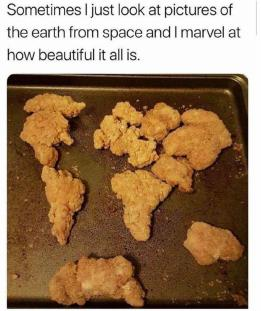

The image features a close-up of a tray filled with various pieces of fried chicken. These pieces are arranged in the shape of a globe, showcasing an artistic and creative presentation. The chicken is spread across the entire surface of the tray, creating a visually appealing display that highlights the delicious nature of the food.



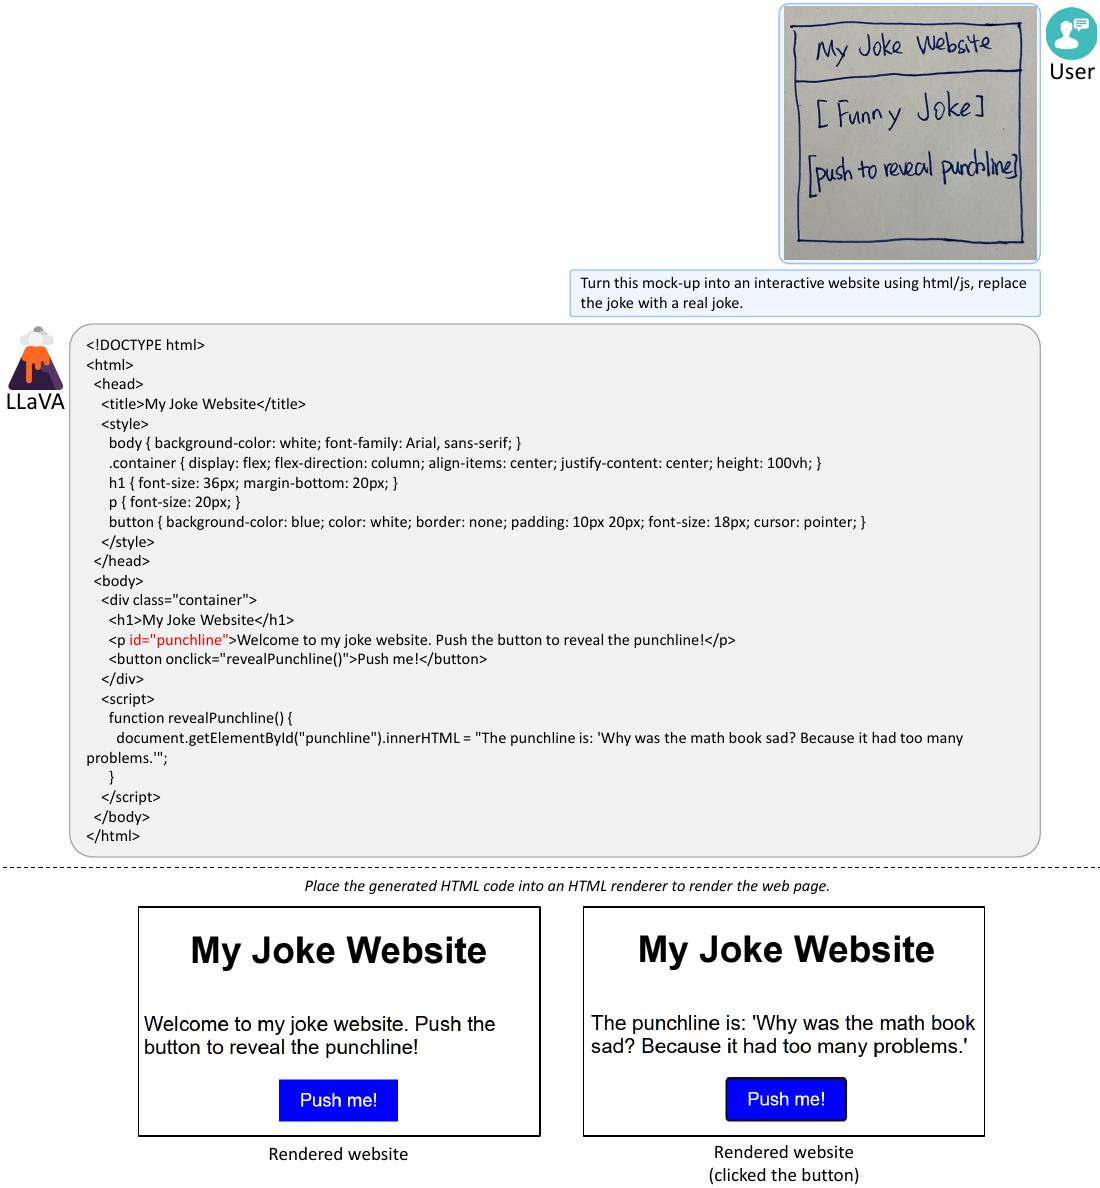

The image features a computer screen with two web pages open. One of the web pages is titled "My Joke Website," while the other page displays a conversation between someone and another person, possibly discussing the joke website. There are also several books visible in the scene, which might be related to the joke website or simply placed nearby. The overall setting appears to be an informal environment where people can enjoy humor and engage with others online.



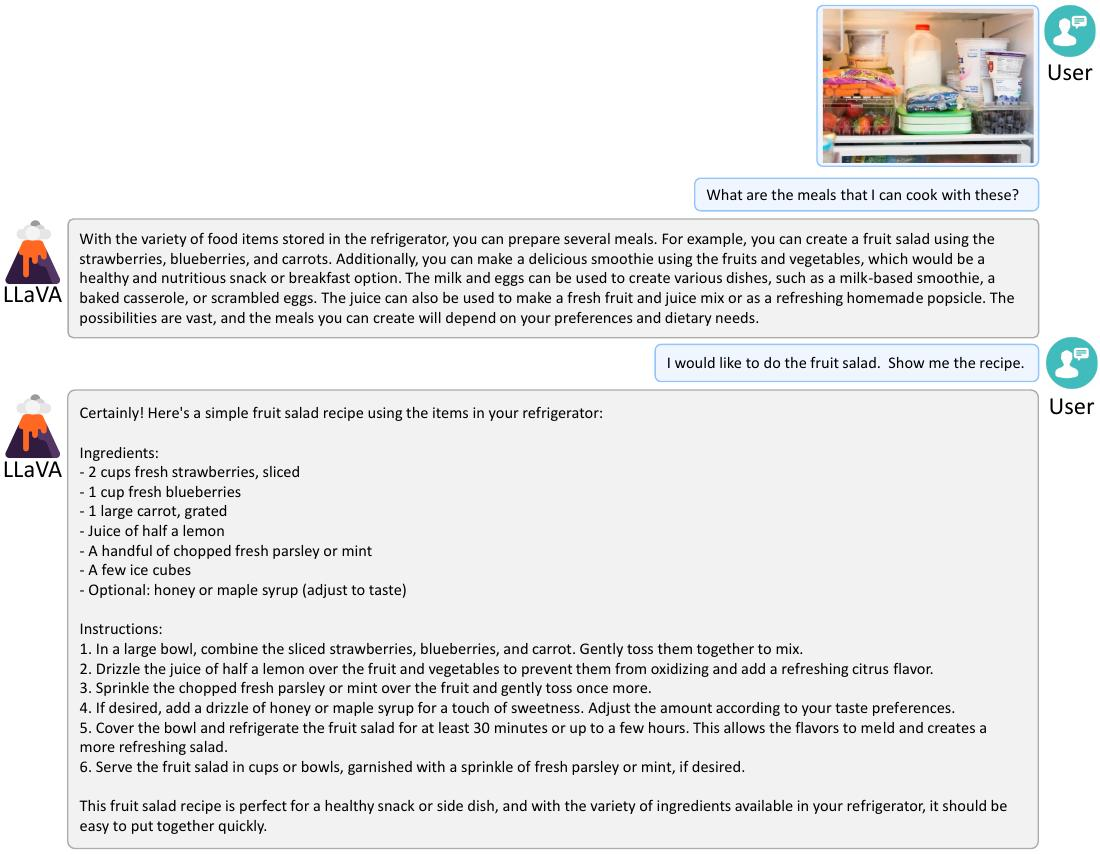

The image is a screenshot of a conversation between two people, likely discussing food and refrigeration. One person has sent a message about using fresh fruits to make smoothies in the refrigerator. The other person responds with an instruction on how to use the refrigerator for preserving or making fruit juices.

There are multiple sentences displayed within the conversation, providing information and guidance related to food storage and preparation. A few sentences also include words like "recipe," "fresh," and "juice." The image captures a moment of interaction between two individuals sharing knowledge about refrigerator usage and fruit-based recipes.



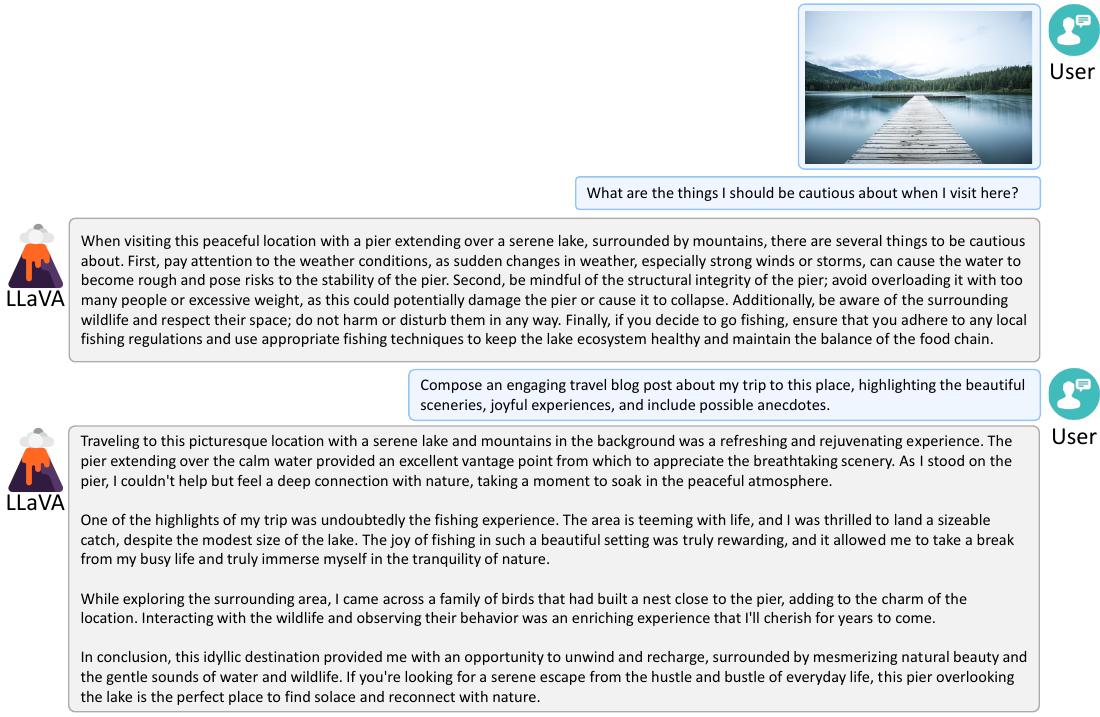

The image is a screenshot of a conversation between two people, possibly on social media or messaging apps. They are discussing the topic of weight loss and fitness, with one person asking about the things they should consider when trying to lose weight.

In the conversation, there are several sentences displayed in different parts of the image. The first sentence is located at the top left corner, while the second sentence can be found near the center-left area. The third sentence appears on the right side of the image, and the fourth sentence is situated towards the bottom left corner.

The conversation also includes a few emojis to convey emotions or reactions, with one located at the top right corner and another in the middle-right section of the image.



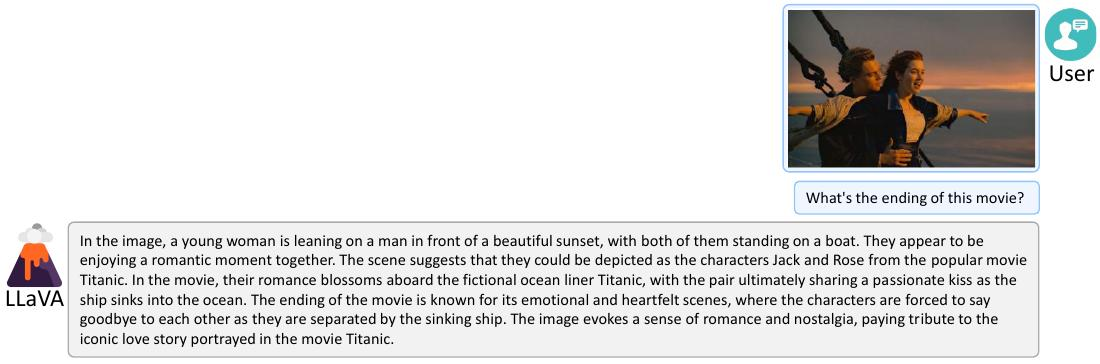

The image features a conversation between two people, with one person asking the other what it's like to be on the moon. The text of their conversation is displayed in the foreground, while an image of a man and woman holding onto a rope can be seen in the background. This scene appears to be related to space exploration or adventure.



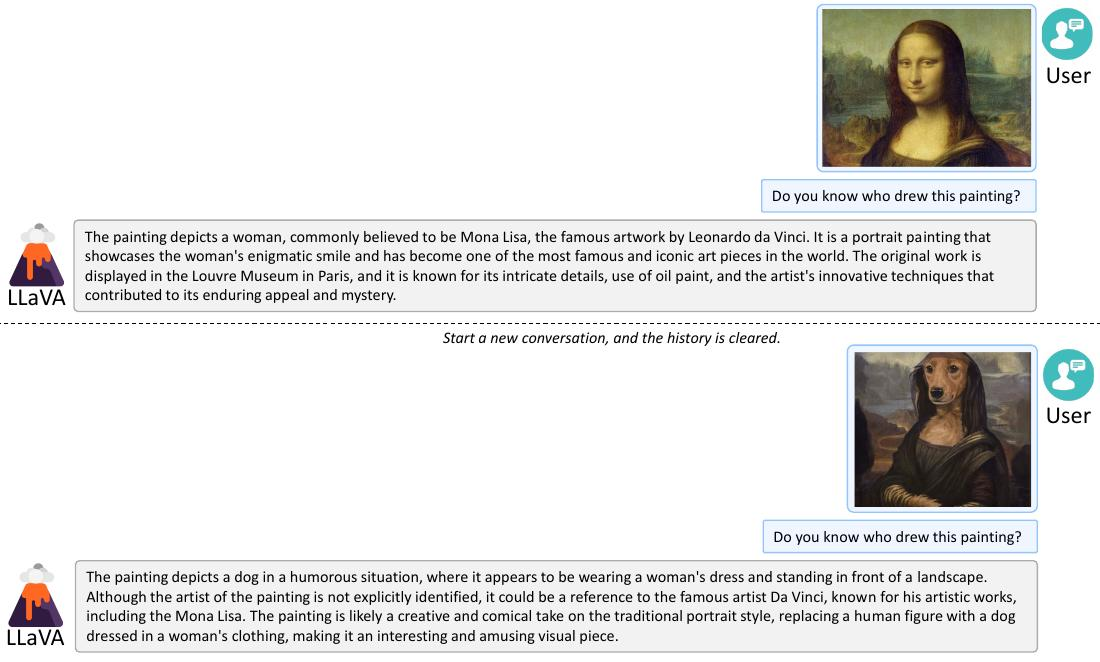

The image is a screenshot of a conversation between two people, likely discussing art and painting. One person is asking the other if they know how to paint, while the other responds with information about the process. There are several sentences displayed in the conversation, including one that says "the painting dog constructs its own picture."

In addition to the text-based conversation, there is a painting of a woman visible on the screen. The image also features a bar graph and a pie chart, which might be related to the discussion about art or painting techniques.



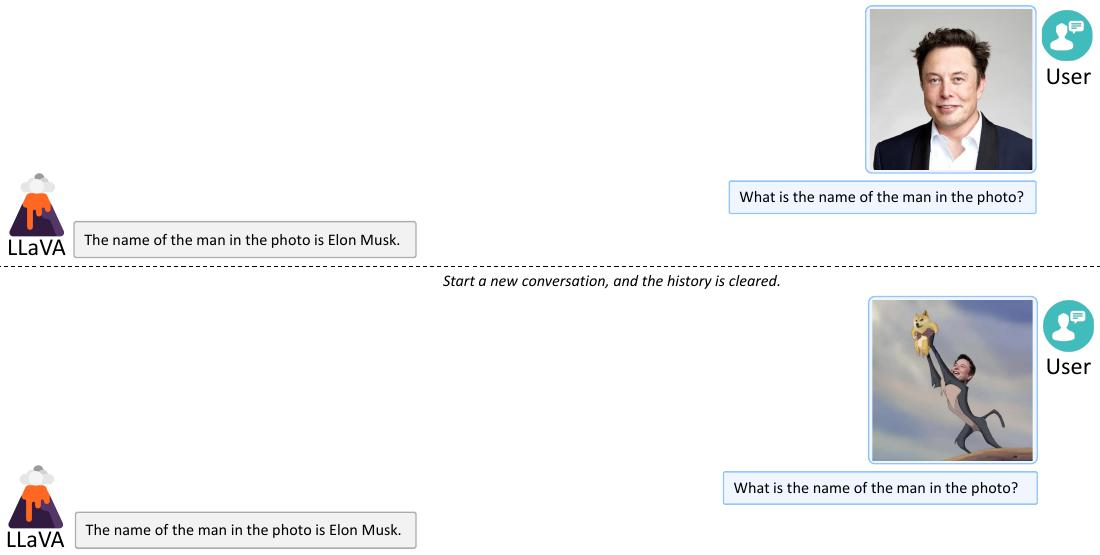

The image features a conversation between two people, with one person asking the other about the name of the man in the picture. The photo is displayed on the left side of the conversation, while the text chat takes place on the right side.

In addition to the main conversation, there are several other elements present in the scene. A bar graph can be seen at the top-left corner of the image, and a pie chart is located near the center of the picture. There's also an arrow pointing towards the photo, indicating its position within the conversation.



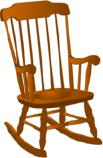

The image features a wooden chair with a brown color, placed in the center of the scene. It is an old-fashioned rocking chair that has been carefully crafted and designed to provide comfort and relaxation. The chair's design includes a cushioned seat and armrests, making it an inviting spot for sitting or resting.



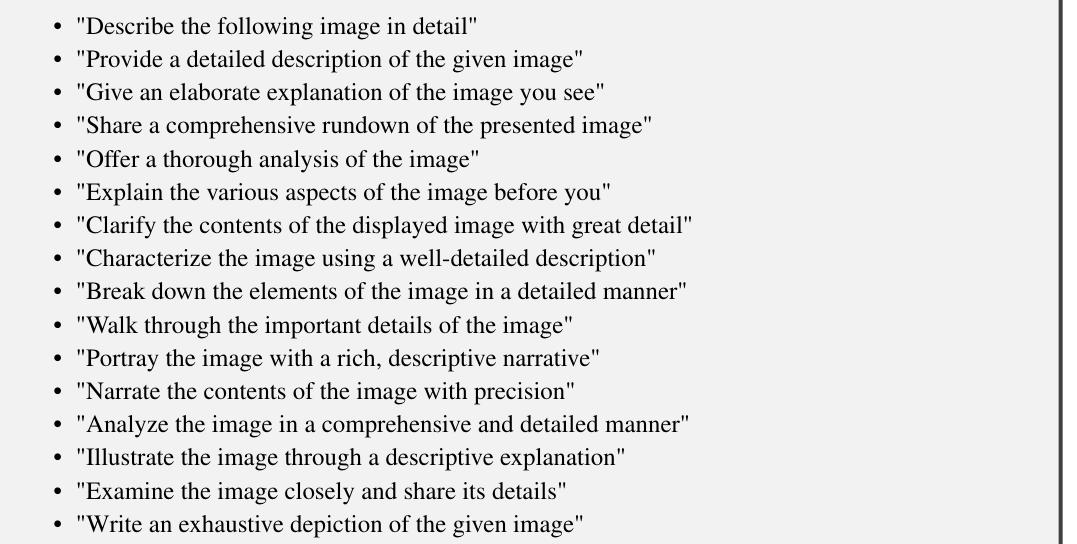

The image is a detailed description of the process involved in analyzing and interpreting an image. It provides information on various aspects such as providing an accurate description, exploring the image's content, understanding the image's context, and breaking down the image into its components.

The image also includes several steps to follow when analyzing a photo, such as giving it a detailed description, providing an accurate depiction of the image, and exploring the image's content. Additionally, there are instructions on how to analyze the image by understanding its context and breaking it down into its components. The image is accompanied by text that provides further guidance on each step in the process.



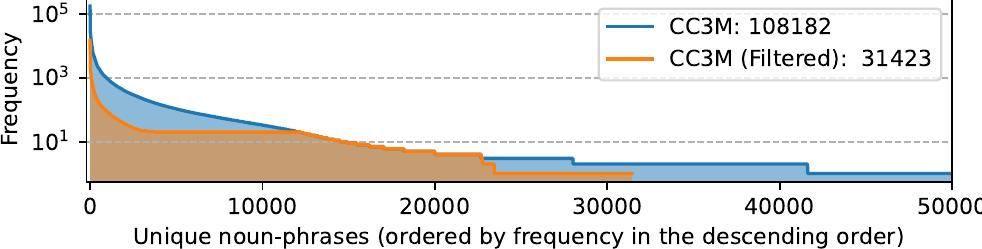

The image displays a graph with two main components: a line and a bar. The line represents the frequency of words, while the bar shows the number of occurrences for each word. This visual representation helps to understand the distribution of certain words in relation to their frequency.



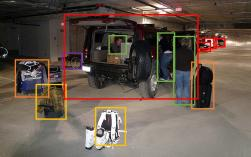

The image features a truck parked in a garage, with several suitcases and backpacks placed around it. There are five suitcases of varying sizes scattered throughout the scene, some closer to the truck while others are further away. Additionally, there are three backpacks located near the truck or on the ground, one close to the left side, another in the middle, and the third towards the right side of the image.

A person can be seen standing next to the parked truck, possibly attending to the luggage or preparing for a trip. The scene appears to depict a busy garage with various items being organized or packed for travel.



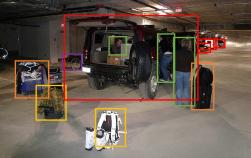

The image depicts a garage with a truck parked inside. There are several people in the scene, some of them standing near the truck and others scattered around the area. A few backpacks can be seen placed on the ground or hanging nearby, indicating that these individuals might have been traveling or working together.

In addition to the people and vehicles, there is a suitcase located in the middle of the scene, possibly belonging to one of the individuals present. The overall atmosphere suggests an active environment where people are engaged in various activities related to the truck and their belongings.



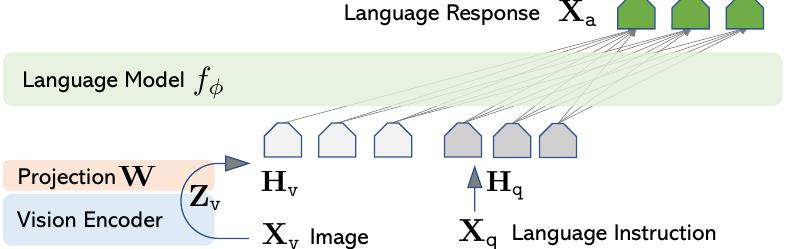

The image is a diagram that explains the process of language modeling and projection. It consists of several diagrams, including one showing the projection of a house onto a wall using a projector. There are also multiple bar graphs illustrating different aspects of the language model, such as vision encoder, projection W, and language instruction.

The diagram is organized in a way that makes it easy to understand the relationship between these concepts. The visual representation helps explain the process of language modeling and its application in various scenarios, like projecting images onto walls or creating language instructions for users.



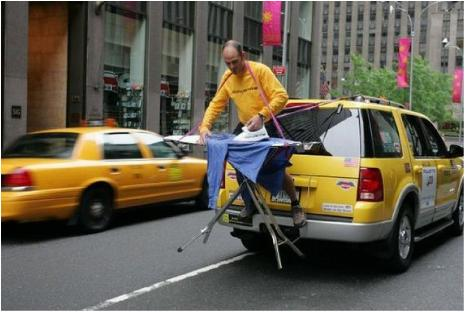

The image captures a busy city street with various vehicles and people. A man is sitting on the back of a yellow taxi, holding up his clothes to dry while they are being ironed by another person in the car. There are also other cars visible in the scene, including one behind the taxi and two others further down the road.

In addition to the vehicles, there are multiple pedestrians walking along the street or waiting at various points. A handbag can be seen near one of the people, possibly belonging to someone passing by. The overall atmosphere suggests a bustling urban environment with people going about their daily activities.



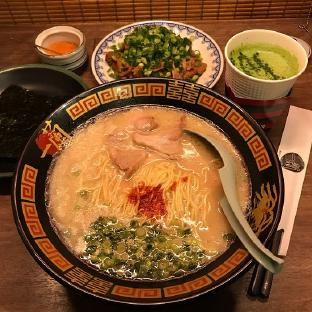

The image features a dining table with various bowls and plates of food, including noodles and vegetables. There are several cups placed around the table, some containing sauces or other beverages. A spoon is also visible on the table, likely used for serving the meal.

In addition to the main dish, there are multiple bowls with different types of food, such as noodles and vegetables. Some of these bowls are placed closer to the center of the table, while others are positioned towards the edges. The variety of food items on the table suggests a diverse and appetizing meal.



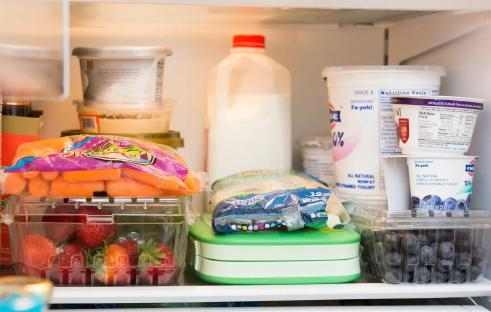

The image displays a refrigerator filled with various food items. Inside the fridge, there are multiple bottles of milk and juice, as well as several containers holding fruits like strawberries and blueberries. There is also a carton of yogurt placed on one side of the refrigerator. The assortment of foods suggests that this refrigerator is well-stocked with fresh produce and beverages for consumption.



In [41]:
from IPython.display import display

for img_dict in img_summaries:
    display(img_dict["image"])
    print(img_dict["summary"])

# Index the Data into a Database

In [42]:
def get_docs(text_list, ids):
    return [
        Document(
            page_content=text,
            metadata={"doc_id": id}
        )
        for text, id in zip(text_list, ids)
    ]

doc_ids = [str(uuid.uuid4()) for _ in text_summaries]

text_docs = get_docs(
    [t["element"] for t in text_summaries],
    doc_ids
)

summary_text_docs = get_docs(
    [t["text"] for t in text_summaries],
    doc_ids
)

table_ids = [str(uuid.uuid4()) for _ in table_summaries]
table_docs = get_docs(
    [t["element"] for t in table_summaries],
    table_ids
)
summary_table_docs = get_docs(
    [t["text"] for t in table_summaries],
    table_ids
)

img_ids = [str(uuid.uuid4()) for _ in img_summaries]
img_summary_docs = get_docs(
    [t["summary"] for t in img_summaries],
    img_ids
)

In [43]:
vectorstore = Chroma(
    collection_name="llava_pdf",
    embedding_function=OpenAIEmbeddings(),
)

store = InMemoryStore()

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key="doc_id",
)

retriever.vectorstore.add_documents(summary_text_docs)
retriever.docstore.mset(list(zip(doc_ids, text_docs)))

retriever.vectorstore.add_documents(summary_table_docs)
retriever.docstore.mset(list(zip(table_ids, table_docs)))

retriever.vectorstore.add_documents(img_summary_docs)
retriever.docstore.mset(list(zip(img_ids, img_summary_docs)))



In [44]:
retriever.vectorstore.similarity_search("What is specific about Llava?")

[Document(page_content="The text discusses the LLaVA system's ability to recognize visual content and generate detailed responses related to the provided visual content. It also mentions a travel blog post about a serene lake location with a pier and mountains, highlighting the beautiful scenery, fishing experience, and interaction with wildlife. The text also describes an image of a young woman and a man on a boat, suggesting they could be characters from the movie Titanic, and briefly summarizes the movie's ending.", metadata={'doc_id': 'b08597a2-0d1c-4cfe-bbb6-b83de053f14c'}),
 Document(page_content='The text discusses the performance and potential of LLaVA, a language model. LLaVA exhibits similar behavior to GPT-4, including generating HTML/JS/CSS code for an interactive website based on user input, and providing detailed responses in a conversational style. It can also relate visual content to textual knowledge. An interesting feature of LLaVA is its ability to understand visual 

In [45]:
retriever.get_relevant_documents("What is specific about Llava?")

[Document(page_content="User What are the things | should be cautious about when | visit here? When visiting this peaceful location with a pier extending over a serene lake, surrounded by mountains, there are several things to be cautious about. First, pay attention to the weather conditions, as sudden changes in weather, especially strong winds or storms, can cause the water to become rough and pose risks to the stability of the pier. Second, be mindful of the structural integrity of the pier; avoid overloading it with too LLaVA\\ many people or excessive weight, as this could potentially damage the pier or cause it to collapse. Additionally, be aware of the surrounding wildlife and respect their space; do not harm or disturb them in any way. Finally, if you decide to go fishing, ensure that you adhere to any local fishing regulations and use appropriate fishing techniques to keep the lake ecosystem healthy and maintain the balance of the food chain. Compose an engaging travel blog po

# Finalizing the RAG Pipeline

In [ ]:
llm = ChatOpenAI(temperature=0)